In [25]:
BAGNUMBER = 2
METHOD = 'opencv - epnp'

In [2]:
import numpy as np
import cv2

import rosbag 

import transforms3d.quaternions as quat

In [26]:
###################
### ALL METHODS ###
###################
def epnp(coor2d, coor3d, cam_matrix, dis_matrix):
    success, rotation, translation = cv2.solvePnP(coor3d, coor2d, cam_matrix, dis_matrix, flags=cv2.SOLVEPNP_EPNP)
    rotation_matrix, _ = cv2.Rodrigues(rotation)
    transformation = np.vstack((np.hstack((rotation_matrix, translation)), [0,0,0,1]))
    transformation = np.linalg.inv(transformation)
    translation = transformation[:3, 3]
    rotation_matrix = transformation[:3, :3]

    rotation_quaternion = quat.mat2quat(rotation_matrix)
    rotation = rotation_quaternion/np.linalg.norm(rotation_quaternion)
    return success, rotation, translation

def func2(coor2d, coor3d, cam_matrix, dis_matrix):
    print("NOT YET")
    return False, np.array([0, 0, 0]), np.array([0, 0, 0])

MethodDict = {
    'opencv - epnp' : epnp,
    '2' : func2
    }

In [27]:
################
### ALL BAGS ###
################
BagPaths = {
    1: '/home/annika/ITRL/kth_thesis/rosbag/2024-01-22/UnitTest_Case1.bag',
    2: '/home/annika/ITRL/kth_thesis/rosbag/2024-01-23/2024-01-23-17-11-22.bag'
    }

Bag = BagPaths[BAGNUMBER]

In [39]:
#########################
### GET DATA FROM BAG ###
#########################
Coor3dAll = []
Coor2dAll = []
IdAll = []

cam_matrix = []
dis_matrix = []

# Open the bag file
with rosbag.Bag(Bag, 'r') as bag:
    # Iterate through messages in the bag
    for topic, msg, t in bag.read_messages():
        coor2d = []
        coor3d = []
        id = []
        # Process the messages based on the topic
        if topic == '/aruco/detection':
            for aruco in msg.arucos:
                id.append(aruco.marker.id)
                coor2d.append([aruco.image_x, aruco.image_y])
                coor3d.append([aruco.marker.pose.pose.position.x, aruco.marker.pose.pose.position.y, aruco.marker.pose.pose.position.z])
            coor2d = np.array(coor2d)
            coor3d = np.array(coor3d)
            Coor2dAll.append(coor2d)
            Coor3dAll.append(coor3d)

            IdAll.append(id)

dis_matrix = np.array([0.06295602826790396, -0.1840231372229633, -0.004945725015870819, 0.01208470957502327, 0])
cam_matrix = np.array([514.578298266441, 0, 340.0718185830948, 0, 514.8684665452305, 231.4918039429434, 0, 0, 1]).reshape(3,3)

In [42]:
Coor2dAll[0]

array([[254.  , 266.  ],
       [312.25, 263.  ],
       [240.5 , 198.5 ],
       [292.  , 198.75]])

In [9]:
suc, rotation, translation = MethodDict[METHOD](coor2d, coor3d, cam_matrix, dis_matrix)

NOT YET


ValueError: not enough values to unpack (expected 4, got 3)

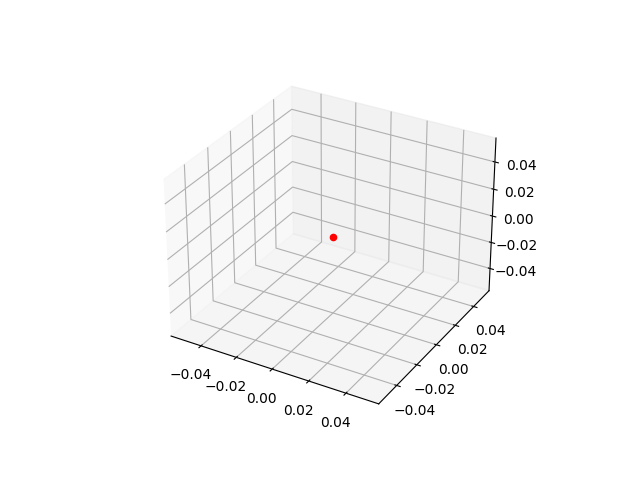

In [10]:
##################
#### PLOTTING ####
##################

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

# Plot translation vector and orientation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot translation vector
ax.scatter(*translation, color='r', label='Translation Vector')

# Plot orientation axis
orientation_axis = quat.qmult(quat.qmult(rotation, [0, 0, 0, 1]), quat.qinverse(rotation))[1:4]
ax.quiver(*translation, *orientation_axis, color='b', label='Orientation Axis', length=0.002, arrow_length_ratio=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Translation Vector and Orientation Axis')
ax.legend()

# Set up interactive 3D rotation
ax.view_init(elev=20, azim=30)  # Set initial view angle

plt.show()